In [3]:
import h5py as h5
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt

In [4]:
from model import unet

# Load test data

The complete dataset consist of 10900 diffraction patterns, simulated with Condor [1] from PDB files. The list of PDB-IDs is saved in a .csv file in ~/data/. 

Twenty patterns from the test dataset are provided in subdirectories of ~/data/testing/. PDB-ID and rotations for these patterns are provided in ~/data/testing/metadata.h5.

[1] Hantke, Ekeberg and Maia. J. Appl. Cryst. (2016). 49, 1356-1362. doi:10.1107/S1600576716009213

In [5]:
no_patterns = 20
size = 128

In [78]:
# Loading noisy patterns (intensity factor: 1000) with a 10 pixels wide mask

dataset_inputs = "./data/testing/noisy&masked/noisy_100_2px.h5"

with h5.File(dataset_inputs, 'r') as data:    
    inputs = np.float32(data['intensity'])
    
# Load ground truth dataset

dataset_groundtruth = "./data/testing/groundtruth/groundtruth.h5"

with h5.File(dataset_groundtruth, 'r') as data:    
    groundtruth = np.float32(data['intensity'])

In [79]:
# Apply log-normalization and reshape arrays 

for i in range(inputs.shape[0]):    
    inputs[i] = np.log(inputs[i] +1)/np.array(np.log(inputs[i] +1)).max()    
inputs = inputs.reshape(inputs.shape + (1,))   

for i in range(groundtruth.shape[0]):    
    groundtruth[i] = np.log(groundtruth[i] +1)/np.array(np.log(groundtruth[i] +1)).max()    
groundtruth = groundtruth.reshape(groundtruth.shape + (1,))   

In [80]:
# Setting inf values to color-code '#440154FF', which is the minimum value in viridis colorbar

import matplotlib

current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='#440154FF')

# Load weights tuned for the specific case

Create and compile the neural network. Trained models are fine-tuned to make predictions under specific experimental conditions (mask size and signal strength). Be sure to load the correct weights.

Weights for the model can be downloaded from https://bit.ly/3qy3Q6Y.

In [82]:
# Compiling model, printing summary of layes and parameters, loading weights
# N.B.: use weigths specific for the mask and noise level applied

model = unet()
model.summary()
model.load_weights('./weights/denoise&demask/2px/denoiseanddemask_100_2px.h5')

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 128, 128, 64) 640         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_72[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 64, 64, 64)   0           conv2d_73[0][0]                  
____________________________________________________________________________________________

In [83]:
predictions = model.predict(inputs)

# Plotting input diffraction data, the ground truth, and predictions

Visualizing four random neural network predictions (with associated input and ground truth) and intensity profiles.

In [102]:
# Parameters for figures: width, heigth, number of columns and rows

w = 16
h = 12
columns = 4
rows = 3

# Seed for displaying four random patterns out of twenty

subset = np.random.randint(0, 20, size=4, dtype=int)

/home/albelli/anaconda3/envs/GPUenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


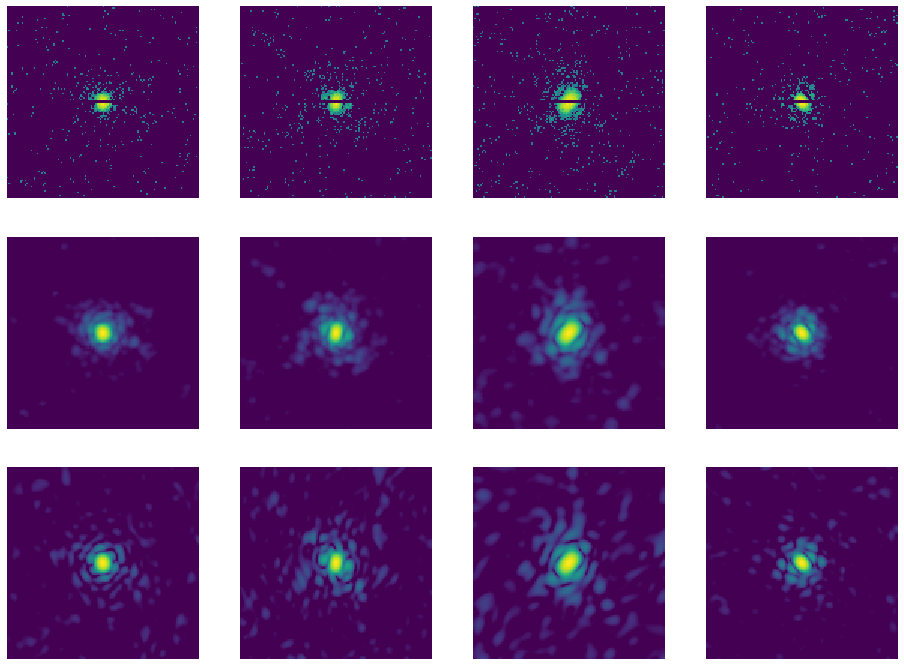

In [103]:
# Plotting linearized data, in log scale, vmin = -8

fig=plt.figure(figsize=(w, h))

for i in range(1, 5):
    img = np.log(np.exp(inputs[int(subset[i-1]),:,:,0]*np.log(1 + 1))-1)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, vmin = -8, vmax  =0)
    plt.axis('off')
    img = np.log(np.exp(predictions[int(subset[i-1]),:,:,0]*np.log(1 + 1))-1)
    fig.add_subplot(rows, columns, i+4)
    plt.imshow(img, vmin = -8, vmax  =0)
    plt.axis('off')    
    img = np.log(np.exp(groundtruth[int(subset[i-1]),:,:,0]*np.log(1 + 1))-1)
    fig.add_subplot(rows, columns, i+8)
    plt.imshow(img, vmin = -8, vmax  =0)
    plt.axis('off')
plt.show()

No handles with labels found to put in legend.


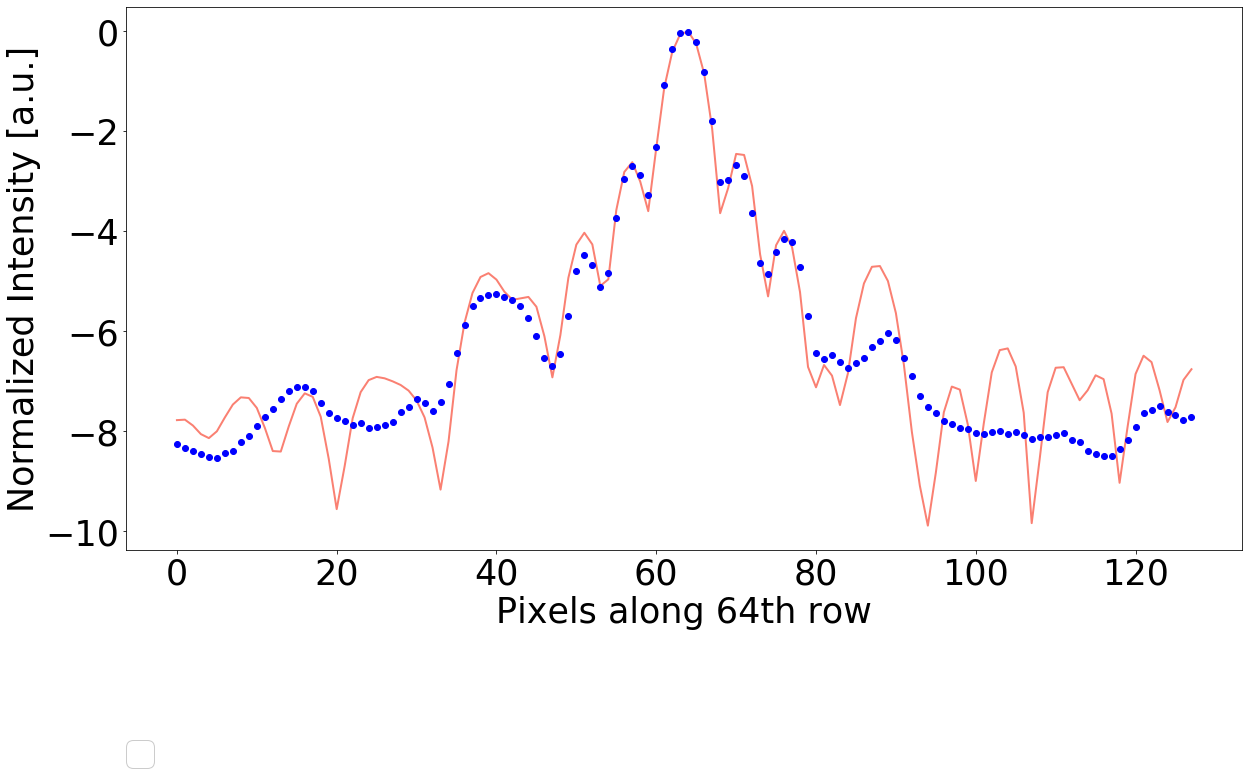

In [87]:
# Plot intensity profile along one row

pattern = np.random.randint(0,20)
row = 64

fig=plt.figure(figsize=(20, 10))

plt.rcParams.update({'font.size': 35})
plt.ylabel('Normalized Intensity [a.u.]')
plt.xlabel('Pixels along {}th row'.format(row))  
plt.legend(loc=(0., -0.4), ncol=2, fancybox=True, framealpha=1)

img = np.log(np.exp(groundtruth[pattern,:,:,0]*np.log(1 + 1))-1)[row]
plt.plot(img, '-', label = 'Ground truth',color = 'salmon',linewidth=2.0)

img = np.log(np.exp(predictions[pattern,:,:,0]*np.log(1 + 1))-1)[row]
plt.plot(img, 'o', label = 'Prediction',color = 'blue',linewidth=2.0)